## Introduction
In this notebook we will demonstrates how to apply Post-training quantization on a keras model with BigDL-Nano.


### Prepare Environment
Before you start with Apis delivered by bigdl-nano, you have to make sure BigDL-Nano is correctly installed for TensorFlow. If not, please follow [this](../../../../../docs/readthedocs/source/doc/Nano/Overview/nano.md) to set up your environment.<br>



By default, Intel Neural Compressor is not installed with BigDL-Nano. So if you determine to use it as your quantization backend, you'll need to install it first:
```bash
pip install neural-compressor==1.11.0
```


BigDL-Nano provides several APIs which can help users easily apply optimizations on inference pipelines to improve latency and throughput. The Keras Model(`bigdl.nano.tf.keras.Model`) and Sequential(`bigdl.nano.tf.keras.Sequential`) provides the APIs for all optimizations you need for inference.


In [1]:
from bigdl.nano.tf.keras import Model, Sequential

### Loading Data
Here we load data from tensorflow_datasets. The ImageNet-v2 is an ImageNet tests set collected by closely following the original labelling protocol.


In [2]:
import tensorflow_datasets as tfds
DATANAME = 'imagenet_v2'
dataset, info = tfds.load(DATANAME, data_dir='../data/', split='test', with_info=True, as_supervised=True)

/root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-21 08:07:51.638115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Visualizing the data
The following code shows the first 6 images with their labels.

,image,label
0,,742 (n04004767)
1,,636 (n03709823)
2,,217 (n02102040)
3,,946 (n07730033)
4,,421 (n02788148)
5,,353 (n02423022)

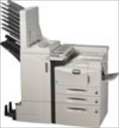
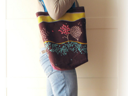
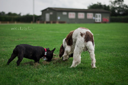
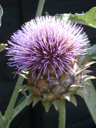
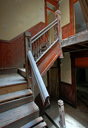
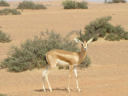

In [3]:
tfds.as_dataframe(dataset.take(6), info)

#### Prepare Inputs
Here we resize the input image to uniform `IMG_SIZE` and the labels are put into one_hot.

In [4]:
import tensorflow as tf
img_size = 224
num_classes = info.features['label'].num_classes
dataset = dataset.map(lambda img, label: (tf.image.resize(img, (img_size, img_size)), tf.one_hot(label, num_classes))).batch(64)


### Build or Load Your Model
Here we initialize the ResNet50 from `tf.keras.applications` with pre-trained ImageNet weights.

In [5]:
from tensorflow.keras.applications import ResNet50
inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.resnet50.preprocess_input(x)
backbone = ResNet50()
outputs = backbone(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [6]:
# testing
from time import time
start = time()
model.evaluate(dataset)
fp32_infer_time = time() - start

  1/157 [..............................] - ETA: 5:34 - loss: 2.2808 - accuracy: 0.5156

tcmalloc: large alloc 1073741824 bytes == 0x5615ffdba000 @  0x7f747b790d3f 0x7f747b7c70c0 0x7f747b7ca082 0x7f747b7ca243 0x7f746ce826ec 0x7f746045eb00 0x7f746045bf39 0x7f746045db82 0x7f746045e119 0x7f746045e7bd 0x7f745f11ffc3 0x7f745739b64c 0x7f74571bdc6d 0x7f7456f109d2 0x7f7456f11200 0x7f7456f113d5 0x7f7460c628c9 0x7f745739d22c 0x7f7457325a57 0x7f74601321d8 0x7f746012dcc3 0x7f7457c96bfa 0x7f747b5c8609 0x7f747b4ed133


157/157 [==============================] - 52s 317ms/step - loss: 2.1141 - accuracy: 0.5654


### Quantization using Intel Neural Compressor
`Model.quantize()` return a Keras module with desired precision and accuracy. Taking Resnet50 as an example, you can add quantization as below.
Get more information about `Model.quantize()` from [here](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Nano/tensorflow.html#bigdl.nano.tf.keras.Model).

In [7]:
from tensorflow.keras.metrics import CategoricalAccuracy
q_model = model.quantize(calib_dataset=dataset,
                         metric=CategoricalAccuracy(),
                         tuning_strategy='basic'
                         )

2022-07-21 08:08:56 [WARNING] Override the value of `metric` field defined in yaml file as user defines the value of `metric` attribute by code.
2022-07-21 08:08:57.310446: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-21 08:08:57.310603: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-07-21 08:08:58.844952: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-21 08:08:58.845141: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-07-21 08:08:59 [INFO] ConvertLayoutOptimizer elapsed time: 0.82 ms
2022-07-21 08:09:03.637513: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


2022-07-21 08:09:07 [WARNING] From /root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/neural_compressor/adaptor/tf_utils/util.py:322: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-07-21 08:09:09 [INFO] Pass StripUnusedNodesOptimizer elapsed time: 2452.76 ms
2022-07-21 08:09:09 [INFO] Pass GraphCseOptimizer elapsed time: 587.69 ms
2022-07-21 08:09:11 [INFO] Pass FoldBatchNormNodesOptimizer elapsed time: 1595.58 ms
2022-07-21 08:09:11 [INFO] Pass UpdateEnterOptimizer elapsed time: 48.56 ms
2022-07-21 08:09:11 [INFO] Pass ConvertLeakyReluOptimizer elapsed time: 50.23 ms
2022-07-21 08:09:11 [INFO] Pass ConvertAddToBiasAddOptimizer elapsed time: 48.89 ms
2022-07-21 08:09:11 [INFO] Pass FuseTransposeReshapeOptimizer elapsed time: 51.8 ms
2022-07-21 08:09:11 [INFO] Pass FuseConvWithMathOptimizer elapsed time: 49.87 ms
2022-0

In [8]:
from time import time
start = time()
for img, _ in dataset:
    q_model(img)
infer_time_int8 = time() - start

### Summary

In [14]:
template = """
|        Precision     | Infer Time(s)     |
|        Default       |       {:5.2f}       |
|     Multi-Instance   |       {:5.2f}       |
|     Improvement(%)   |       {:5.2f}       |
"""
summary = template.format(
    fp32_infer_time,
    infer_time_int8,
    (1 - infer_time_int8/fp32_infer_time) * 100
)
print(summary)


|        Precision     | Infer Time(s)     |
|        Default       |       51.68       |
|     Multi-Instance   |       12.16       |
|     Improvement(%)   |       76.48       |

